In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Load the pickle file
with open('training-data-bitstrings-1727884000295915700.pkl', 'rb') as f:
    data = pickle.load(f)

# Unpack the data
X, y = data

# Convert y to a DataFrame for easier handling
df_y = pd.DataFrame(y, columns=['num_included', 'num_excluded'])

1. Dataset Overview
Number of samples: 10000
Shape of y: (10000, 2)

Target variables summary:
       num_included  num_excluded
count  10000.000000  10000.000000
mean     501.602300    497.770300
std      288.683854    289.957733
min        1.000000      1.000000
25%      255.000000    245.000000
50%      501.000000    498.000000
75%      750.000000    749.000000
max     1000.000000   1000.000000


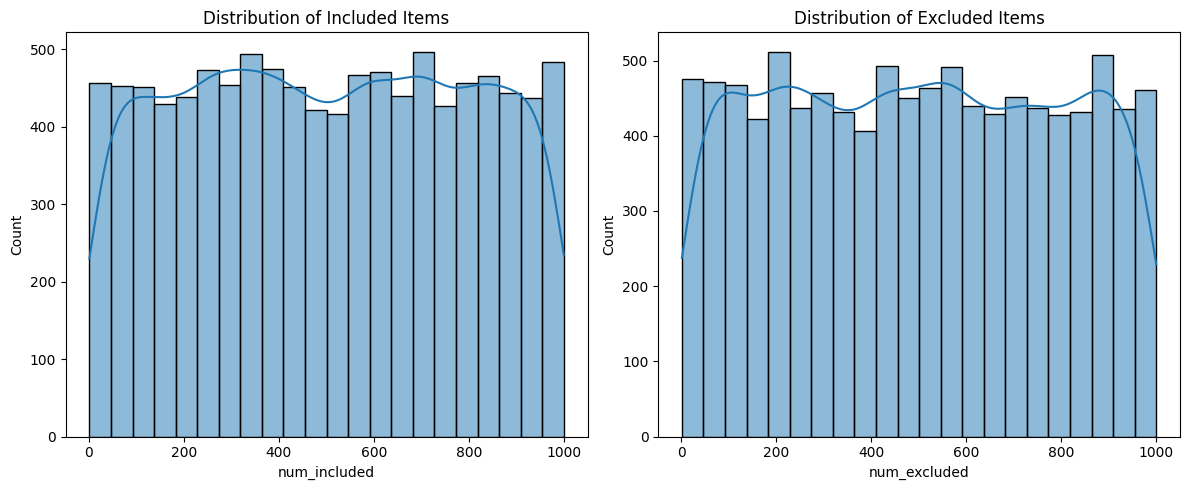

In [5]:
# 1. Dataset Overview
print("1. Dataset Overview")
print(f"Number of samples: {len(X)}")
print(f"Shape of y: {y.shape}")
print("\nTarget variables summary:")
print(df_y.describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_y['num_included'], kde=True)
plt.title('Distribution of Included Items')
plt.subplot(1, 2, 2)
sns.histplot(df_y['num_excluded'], kde=True)
plt.title('Distribution of Excluded Items')
plt.tight_layout()
plt.show()

In [6]:
# 2. Raw Data Exploration
print("\n2. Raw Data Exploration")

def bytes_to_binary(byte_string):
    return ''.join(format(byte, '08b') for byte in byte_string)

# Display the first few samples
for i in range(min(5, len(X))):
    print(f"\nSample {i+1}:")
    print(f"Number of included items: {df_y.iloc[i]['num_included']}")
    print(f"Number of excluded items: {df_y.iloc[i]['num_excluded']}")
    print(f"Number of filters: {len(X[i])}")
    for j, filter_bytes in enumerate(X[i]):
        binary = bytes_to_binary(filter_bytes)
        print(f"  Filter {j+1}: {len(binary)} bits")
        print(f"    First 100 bits: {binary[:100]}...")
        print(f"    Number of set bits: {binary.count('1')}")


2. Raw Data Exploration

Sample 1:
Number of included items: 774.0
Number of excluded items: 169.0
Number of filters: 1
  Filter 1: 12848 bits
    First 100 bits: 0000011100000000000000000000000000000000000000000000000000000000101001100001111010101010110110111110...
    Number of set bits: 5415

Sample 2:
Number of included items: 967.0
Number of excluded items: 963.0
Number of filters: 2
  Filter 1: 12848 bits
    First 100 bits: 0000011100000000000000000000000000000000000000000000000000000000101100101010000001010011111010010101...
    Number of set bits: 5358
  Filter 2: 88 bits
    First 100 bits: 0000011100000000000000000000000000000000000000000000000000000000000000100100001011001001...
    Number of set bits: 10

Sample 3:
Number of included items: 980.0
Number of excluded items: 3.0
Number of filters: 3
  Filter 1: 12848 bits
    First 100 bits: 0000011100000000000000000000000000000000000000000000000000000000101010100101001011000100110101100010...
    Number of set bits: 5407
  


3. Number of Filters Analysis
Number of filters per sample:
1     940
2    4645
3    4264
4     149
5       2
Name: count, dtype: int64


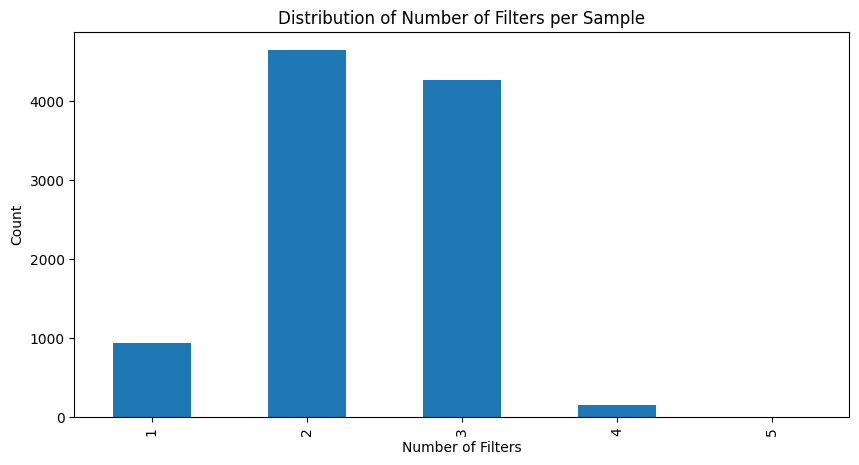

In [7]:
# 3. Number of Filters Analysis
print("\n3. Number of Filters Analysis")
num_filters = [len(sample) for sample in X]
filter_counts = pd.Series(num_filters).value_counts().sort_index()
print("Number of filters per sample:")
print(filter_counts)

plt.figure(figsize=(10, 5))
filter_counts.plot(kind='bar')
plt.title('Distribution of Number of Filters per Sample')
plt.xlabel('Number of Filters')
plt.ylabel('Count')
plt.show()


4. Filter Length Analysis

Average length of each filter position:
Filter 1: 12848.00 bits
Filter 2: 105.34 bits
Filter 3: 98.47 bits
Filter 4: 88.48 bits
Filter 5: 88.00 bits


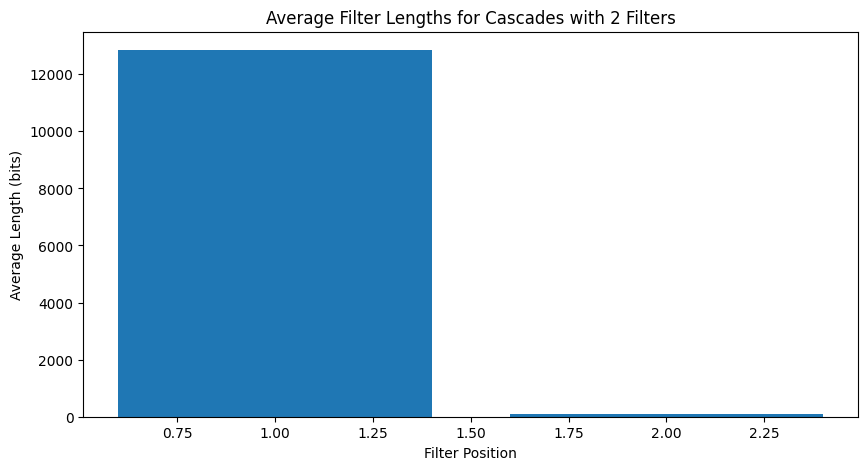

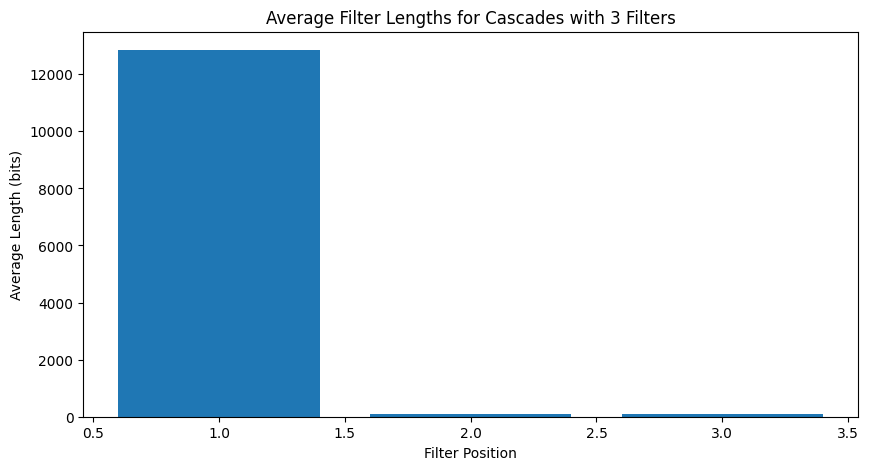

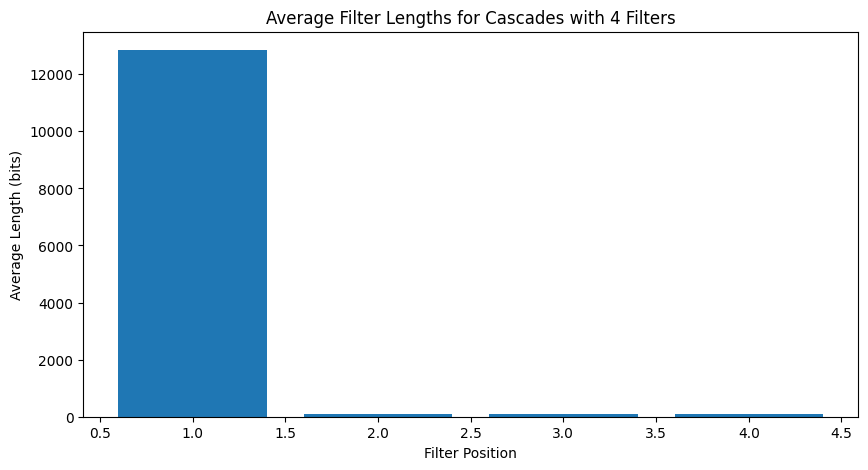

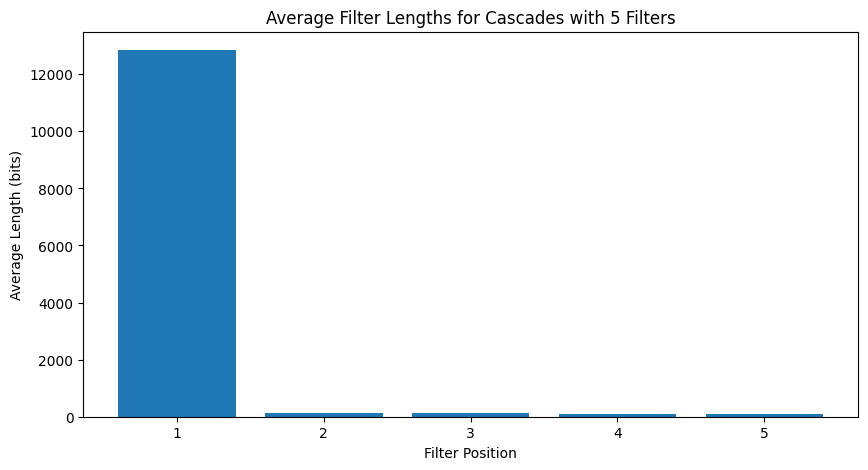

In [8]:
# 4. Filter Length Analysis
print("\n4. Filter Length Analysis")
filter_lengths = [[len(bytes_to_binary(filter_bytes)) for filter_bytes in sample] for sample in X]

# Average length of each filter position
avg_lengths = pd.DataFrame(filter_lengths).mean().to_dict()
print("\nAverage length of each filter position:")
for pos, length in avg_lengths.items():
    print(f"Filter {pos+1}: {length:.2f} bits")

# Plot average filter lengths for each filter number
max_filters = max(num_filters)
for n in range(2, max_filters + 1):
    lengths_n_filters = [lengths for lengths, num in zip(filter_lengths, num_filters) if num == n]
    if lengths_n_filters:
        avg_lengths_n = np.mean(lengths_n_filters, axis=0)
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, n+1), avg_lengths_n)
        plt.title(f'Average Filter Lengths for Cascades with {n} Filters')
        plt.xlabel('Filter Position')
        plt.ylabel('Average Length (bits)')
        plt.show()

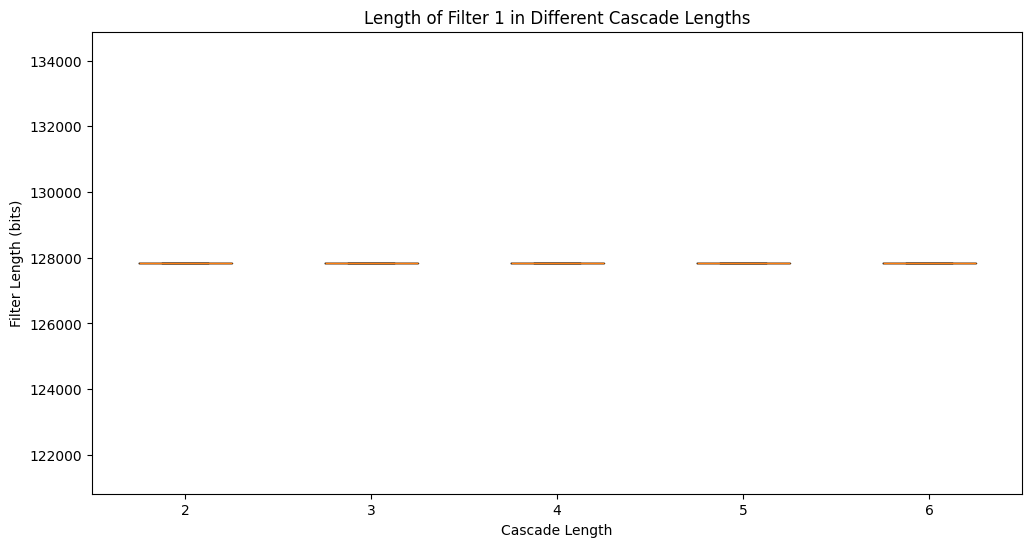

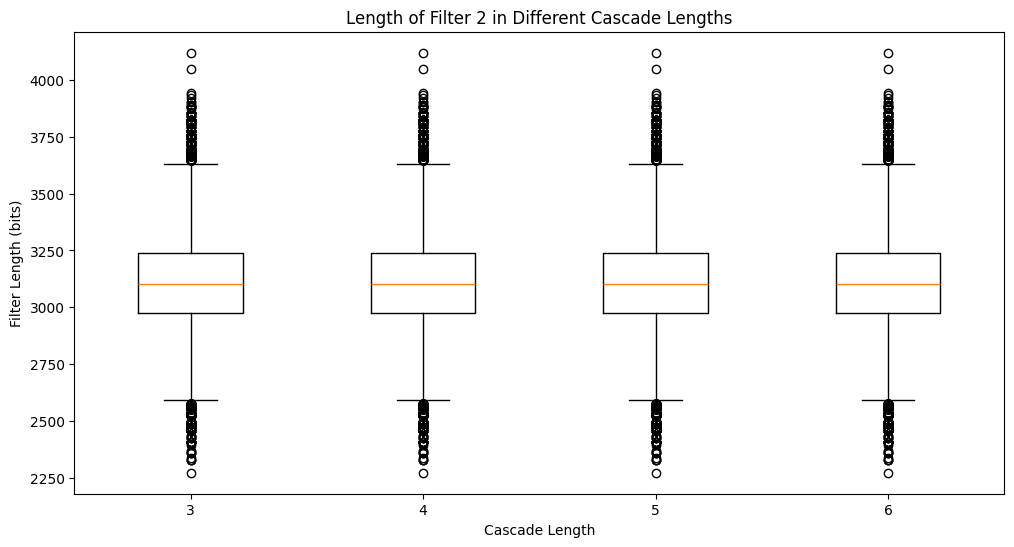

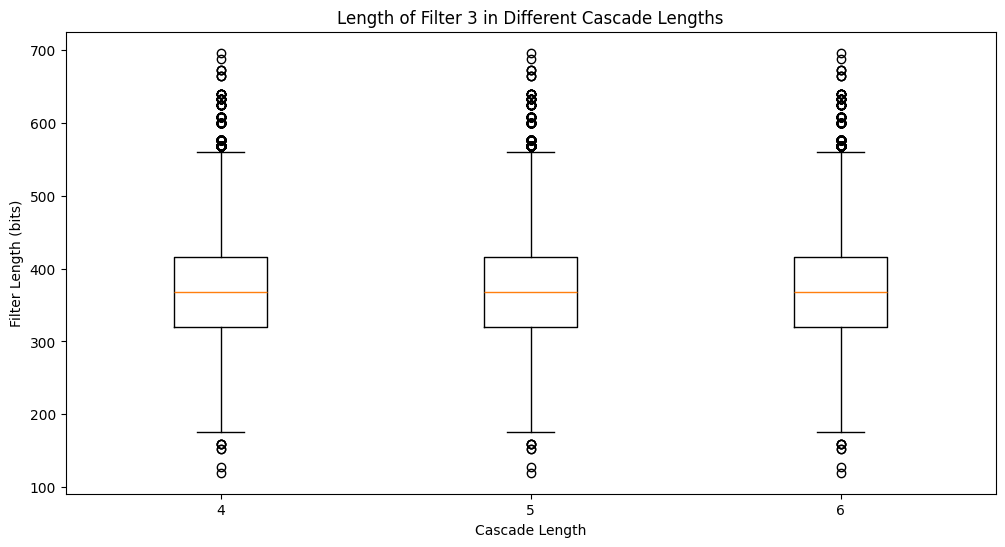

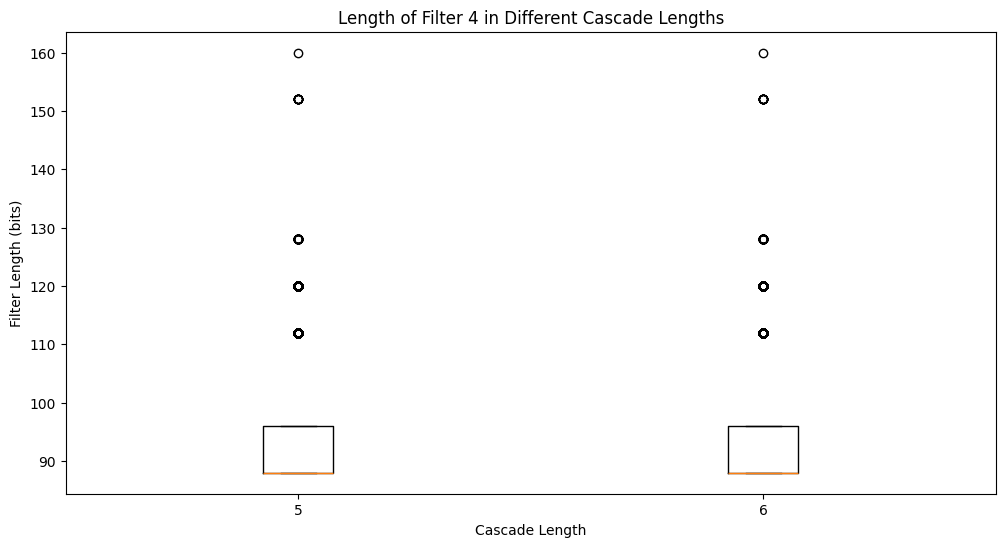

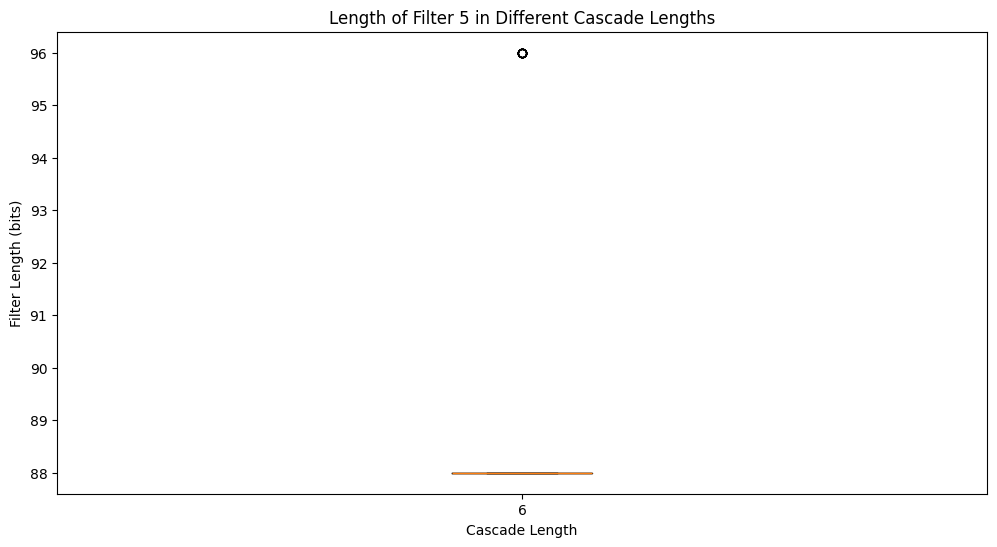

In [13]:
# Compare specific filter positions across different cascade lengths
for filter_pos in range(max_filters):
    lengths_by_cascade = [
        [lengths[filter_pos] for lengths, num in zip(filter_lengths, num_filters) if num > filter_pos]
        for cascade_length in range(filter_pos + 2, max_filters + 1)
    ]
    
    if any(lengths_by_cascade):
        plt.figure(figsize=(12, 6))
        plt.boxplot(lengths_by_cascade)
        plt.title(f'Length of Filter {filter_pos + 1} in Different Cascade Lengths')
        plt.xlabel('Cascade Length')
        plt.ylabel('Filter Length (bits)')
        plt.xticks(range(1, len(lengths_by_cascade) + 1), 
                   [str(i) for i in range(filter_pos + 2, max_filters + 1)])
        plt.show()


5. Bit Density Analysis


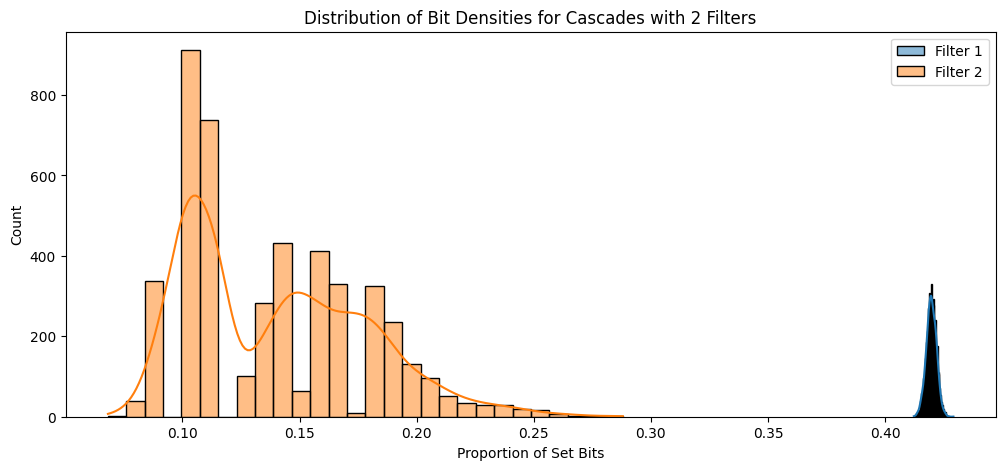

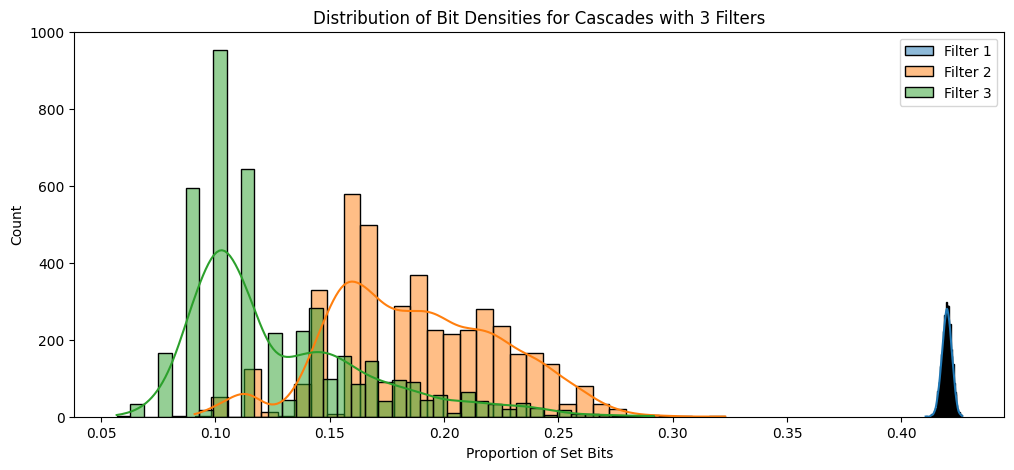

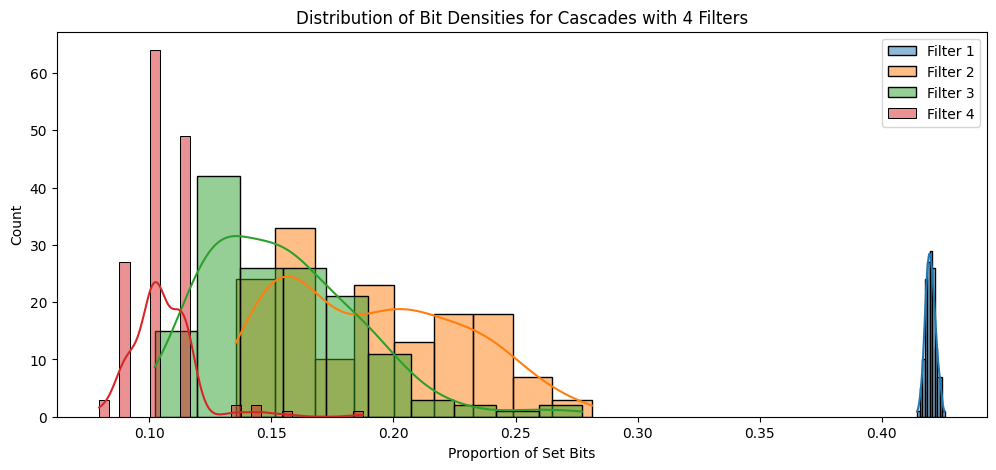

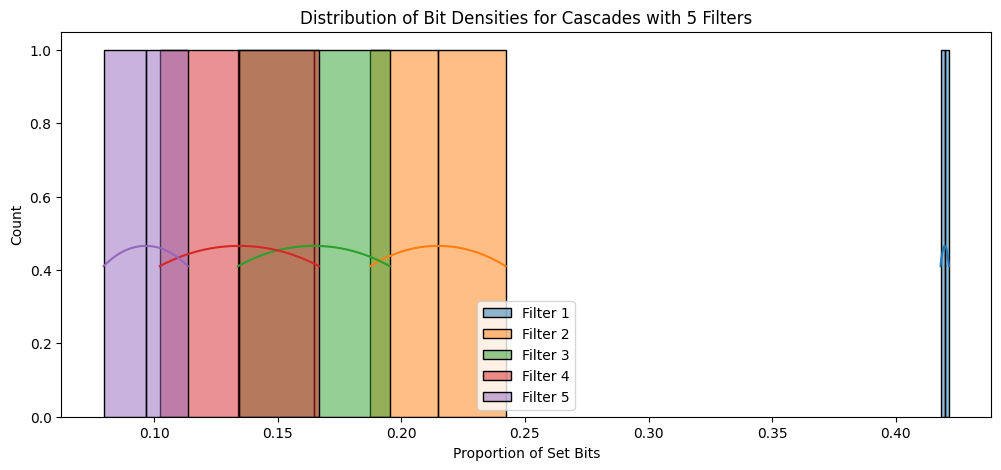

In [9]:
# 5. Bit Density Analysis
print("\n5. Bit Density Analysis")
bit_densities = [[bytes_to_binary(filter_bytes).count('1') / len(bytes_to_binary(filter_bytes)) 
                  for filter_bytes in sample] for sample in X]

# Plot bit densities for each filter position, separated by number of filters
for n in range(2, max_filters + 1):
    densities_n_filters = [densities for densities, num in zip(bit_densities, num_filters) if num == n]
    if densities_n_filters:
        plt.figure(figsize=(12, 5))
        for i in range(n):
            sns.histplot([d[i] for d in densities_n_filters], kde=True, label=f'Filter {i+1}')
        plt.title(f'Distribution of Bit Densities for Cascades with {n} Filters')
        plt.xlabel('Proportion of Set Bits')
        plt.legend()
        plt.show()

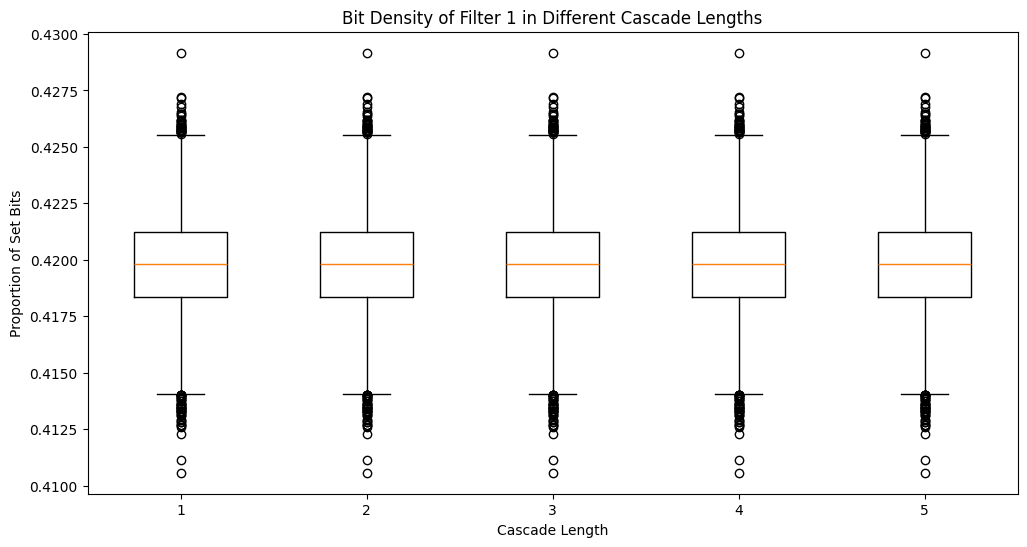

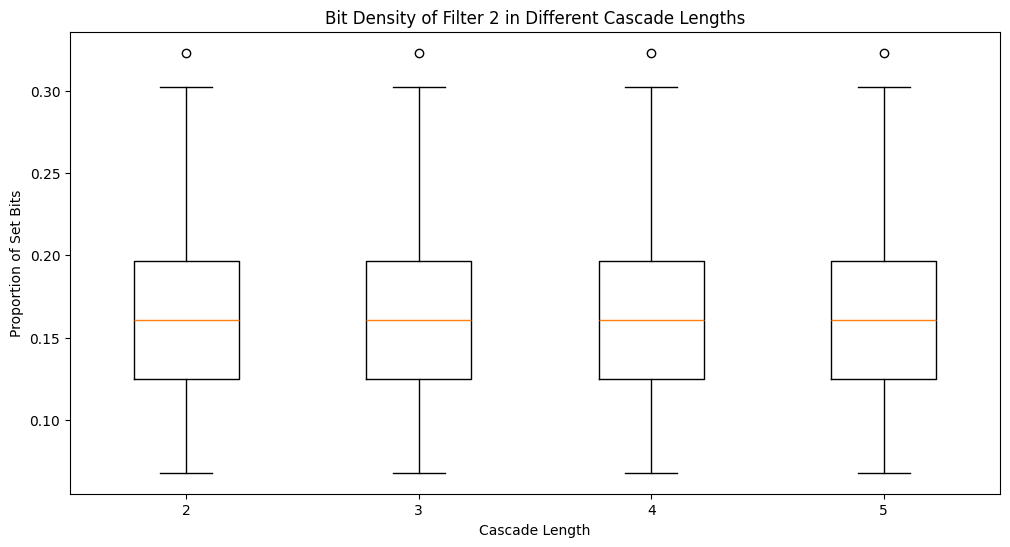

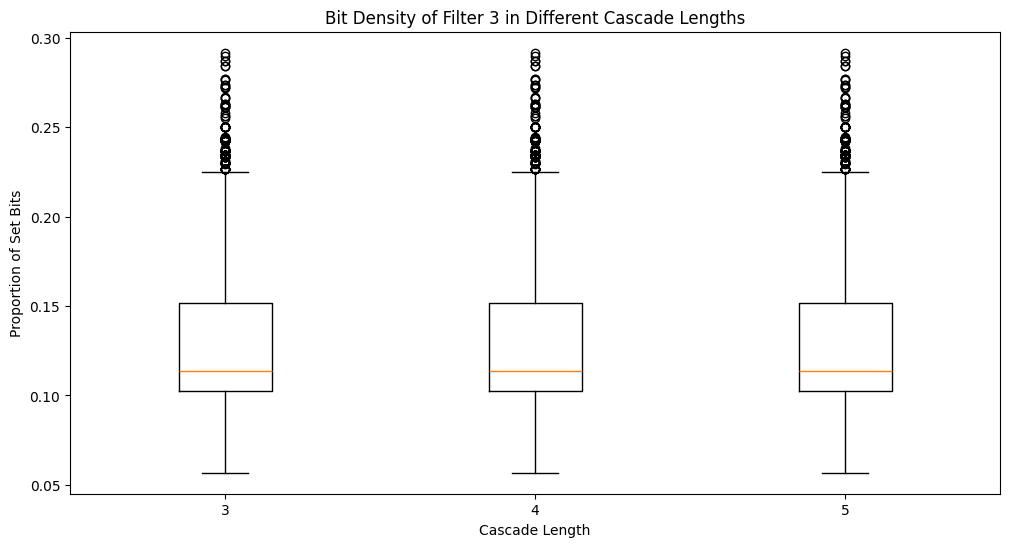

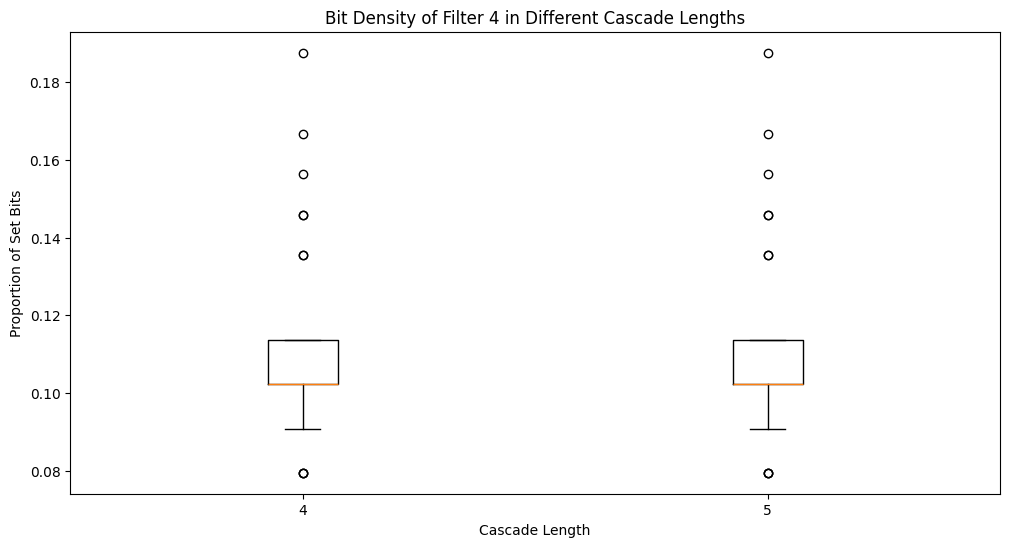

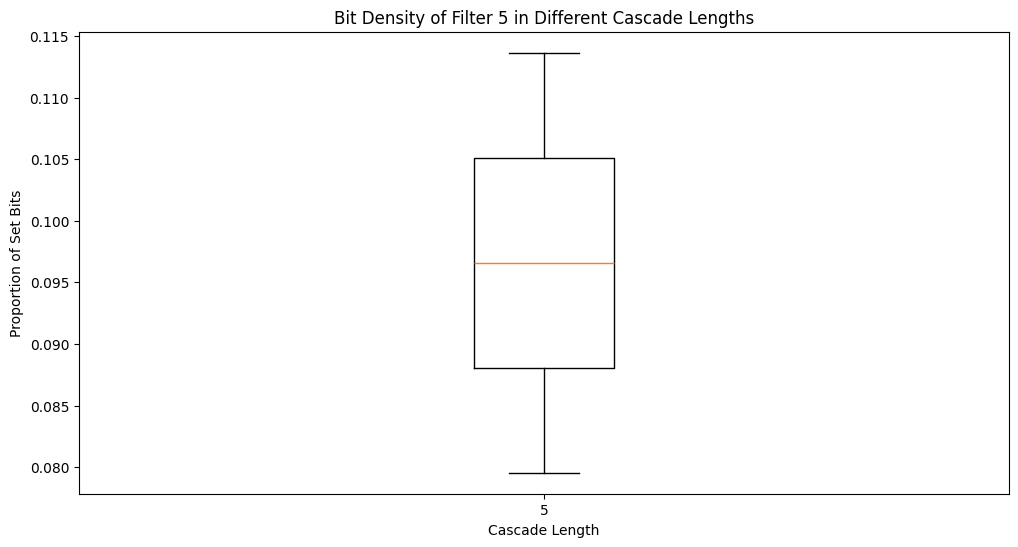

In [10]:
# Compare specific filter positions across different cascade lengths
for filter_pos in range(max_filters):
    densities_by_cascade = [
        [densities[filter_pos] for densities, num in zip(bit_densities, num_filters) if num > filter_pos]
        for cascade_length in range(filter_pos + 1, max_filters + 1)
    ]
    
    if any(densities_by_cascade):
        plt.figure(figsize=(12, 6))
        plt.boxplot(densities_by_cascade)
        plt.title(f'Bit Density of Filter {filter_pos + 1} in Different Cascade Lengths')
        plt.xlabel('Cascade Length')
        plt.ylabel('Proportion of Set Bits')
        plt.xticks(range(1, len(densities_by_cascade) + 1), 
                   [str(i) for i in range(filter_pos + 1, max_filters + 1)])
        plt.show()

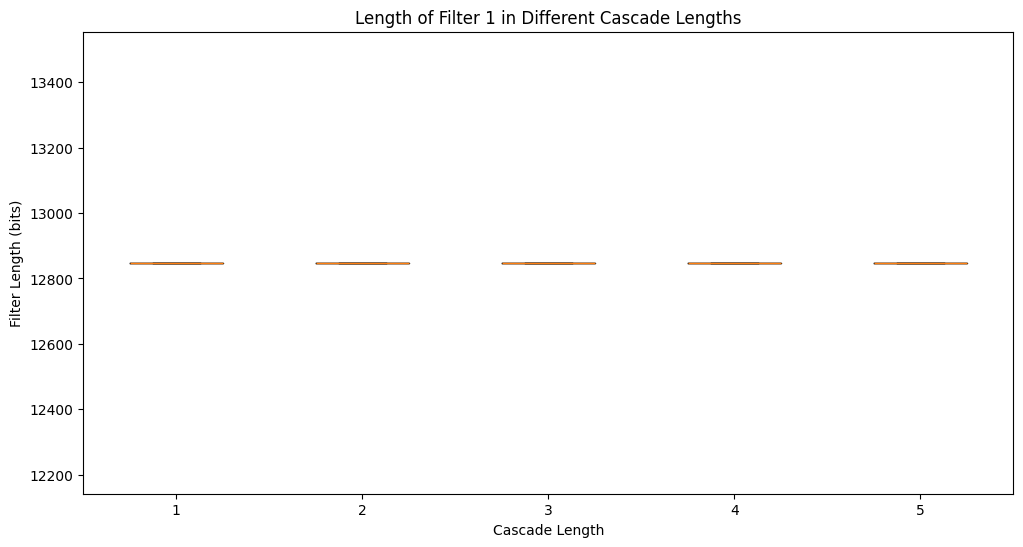

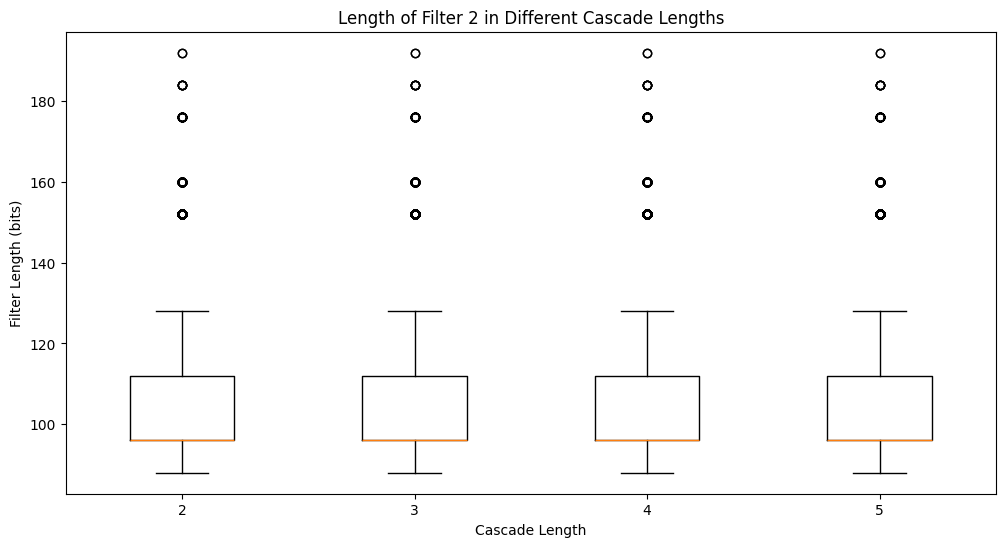

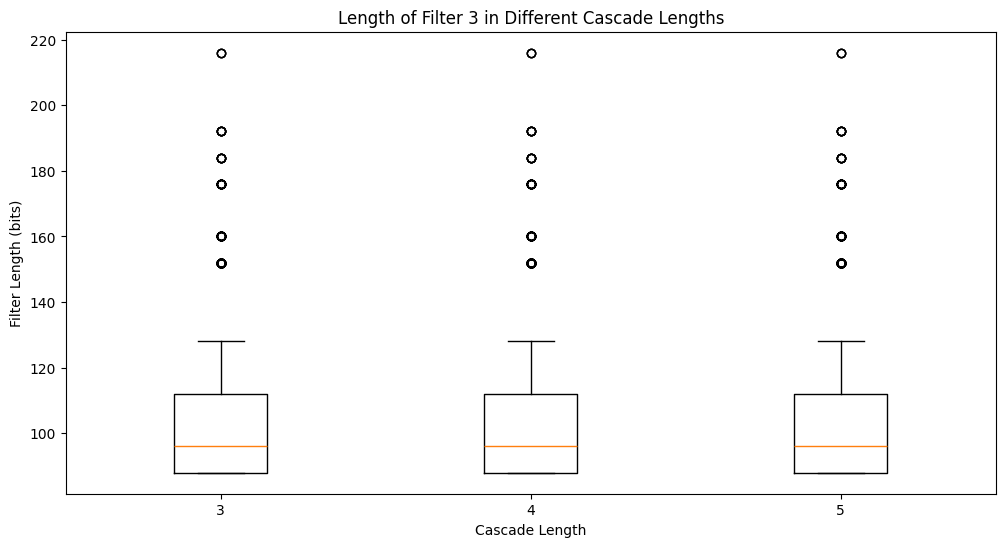

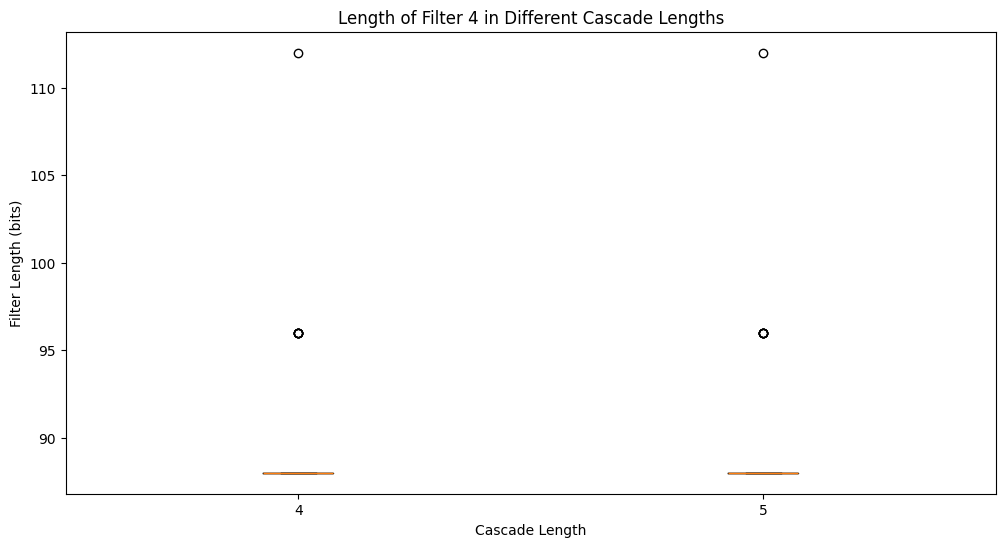

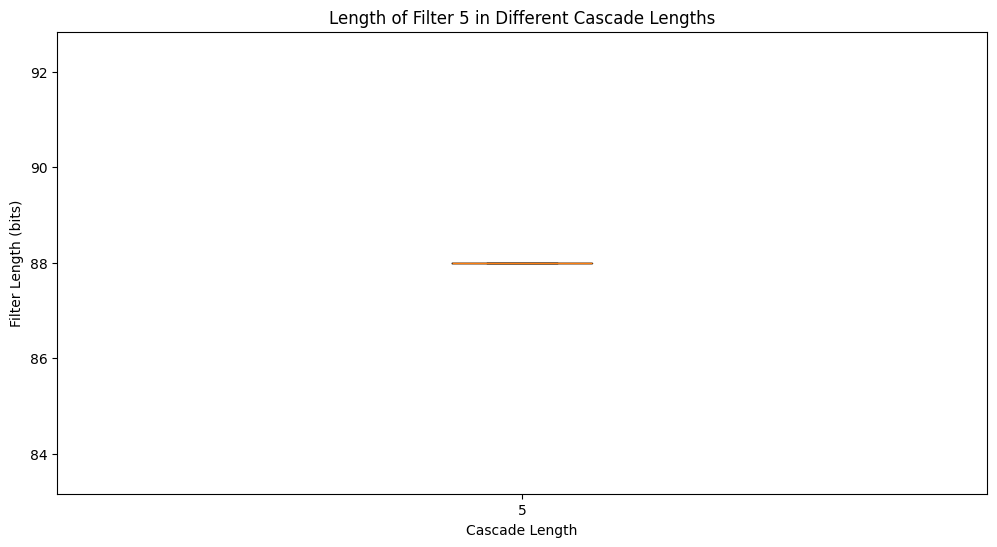

In [11]:
# Make sure to apply the same change to the filter length comparison
for filter_pos in range(max_filters):
    lengths_by_cascade = [
        [lengths[filter_pos] for lengths, num in zip(filter_lengths, num_filters) if num > filter_pos]
        for cascade_length in range(filter_pos + 1, max_filters + 1)
    ]
    
    if any(lengths_by_cascade):
        plt.figure(figsize=(12, 6))
        plt.boxplot(lengths_by_cascade)
        plt.title(f'Length of Filter {filter_pos + 1} in Different Cascade Lengths')
        plt.xlabel('Cascade Length')
        plt.ylabel('Filter Length (bits)')
        plt.xticks(range(1, len(lengths_by_cascade) + 1), 
                   [str(i) for i in range(filter_pos + 1, max_filters + 1)])
        plt.show()


6. Relationship Analysis


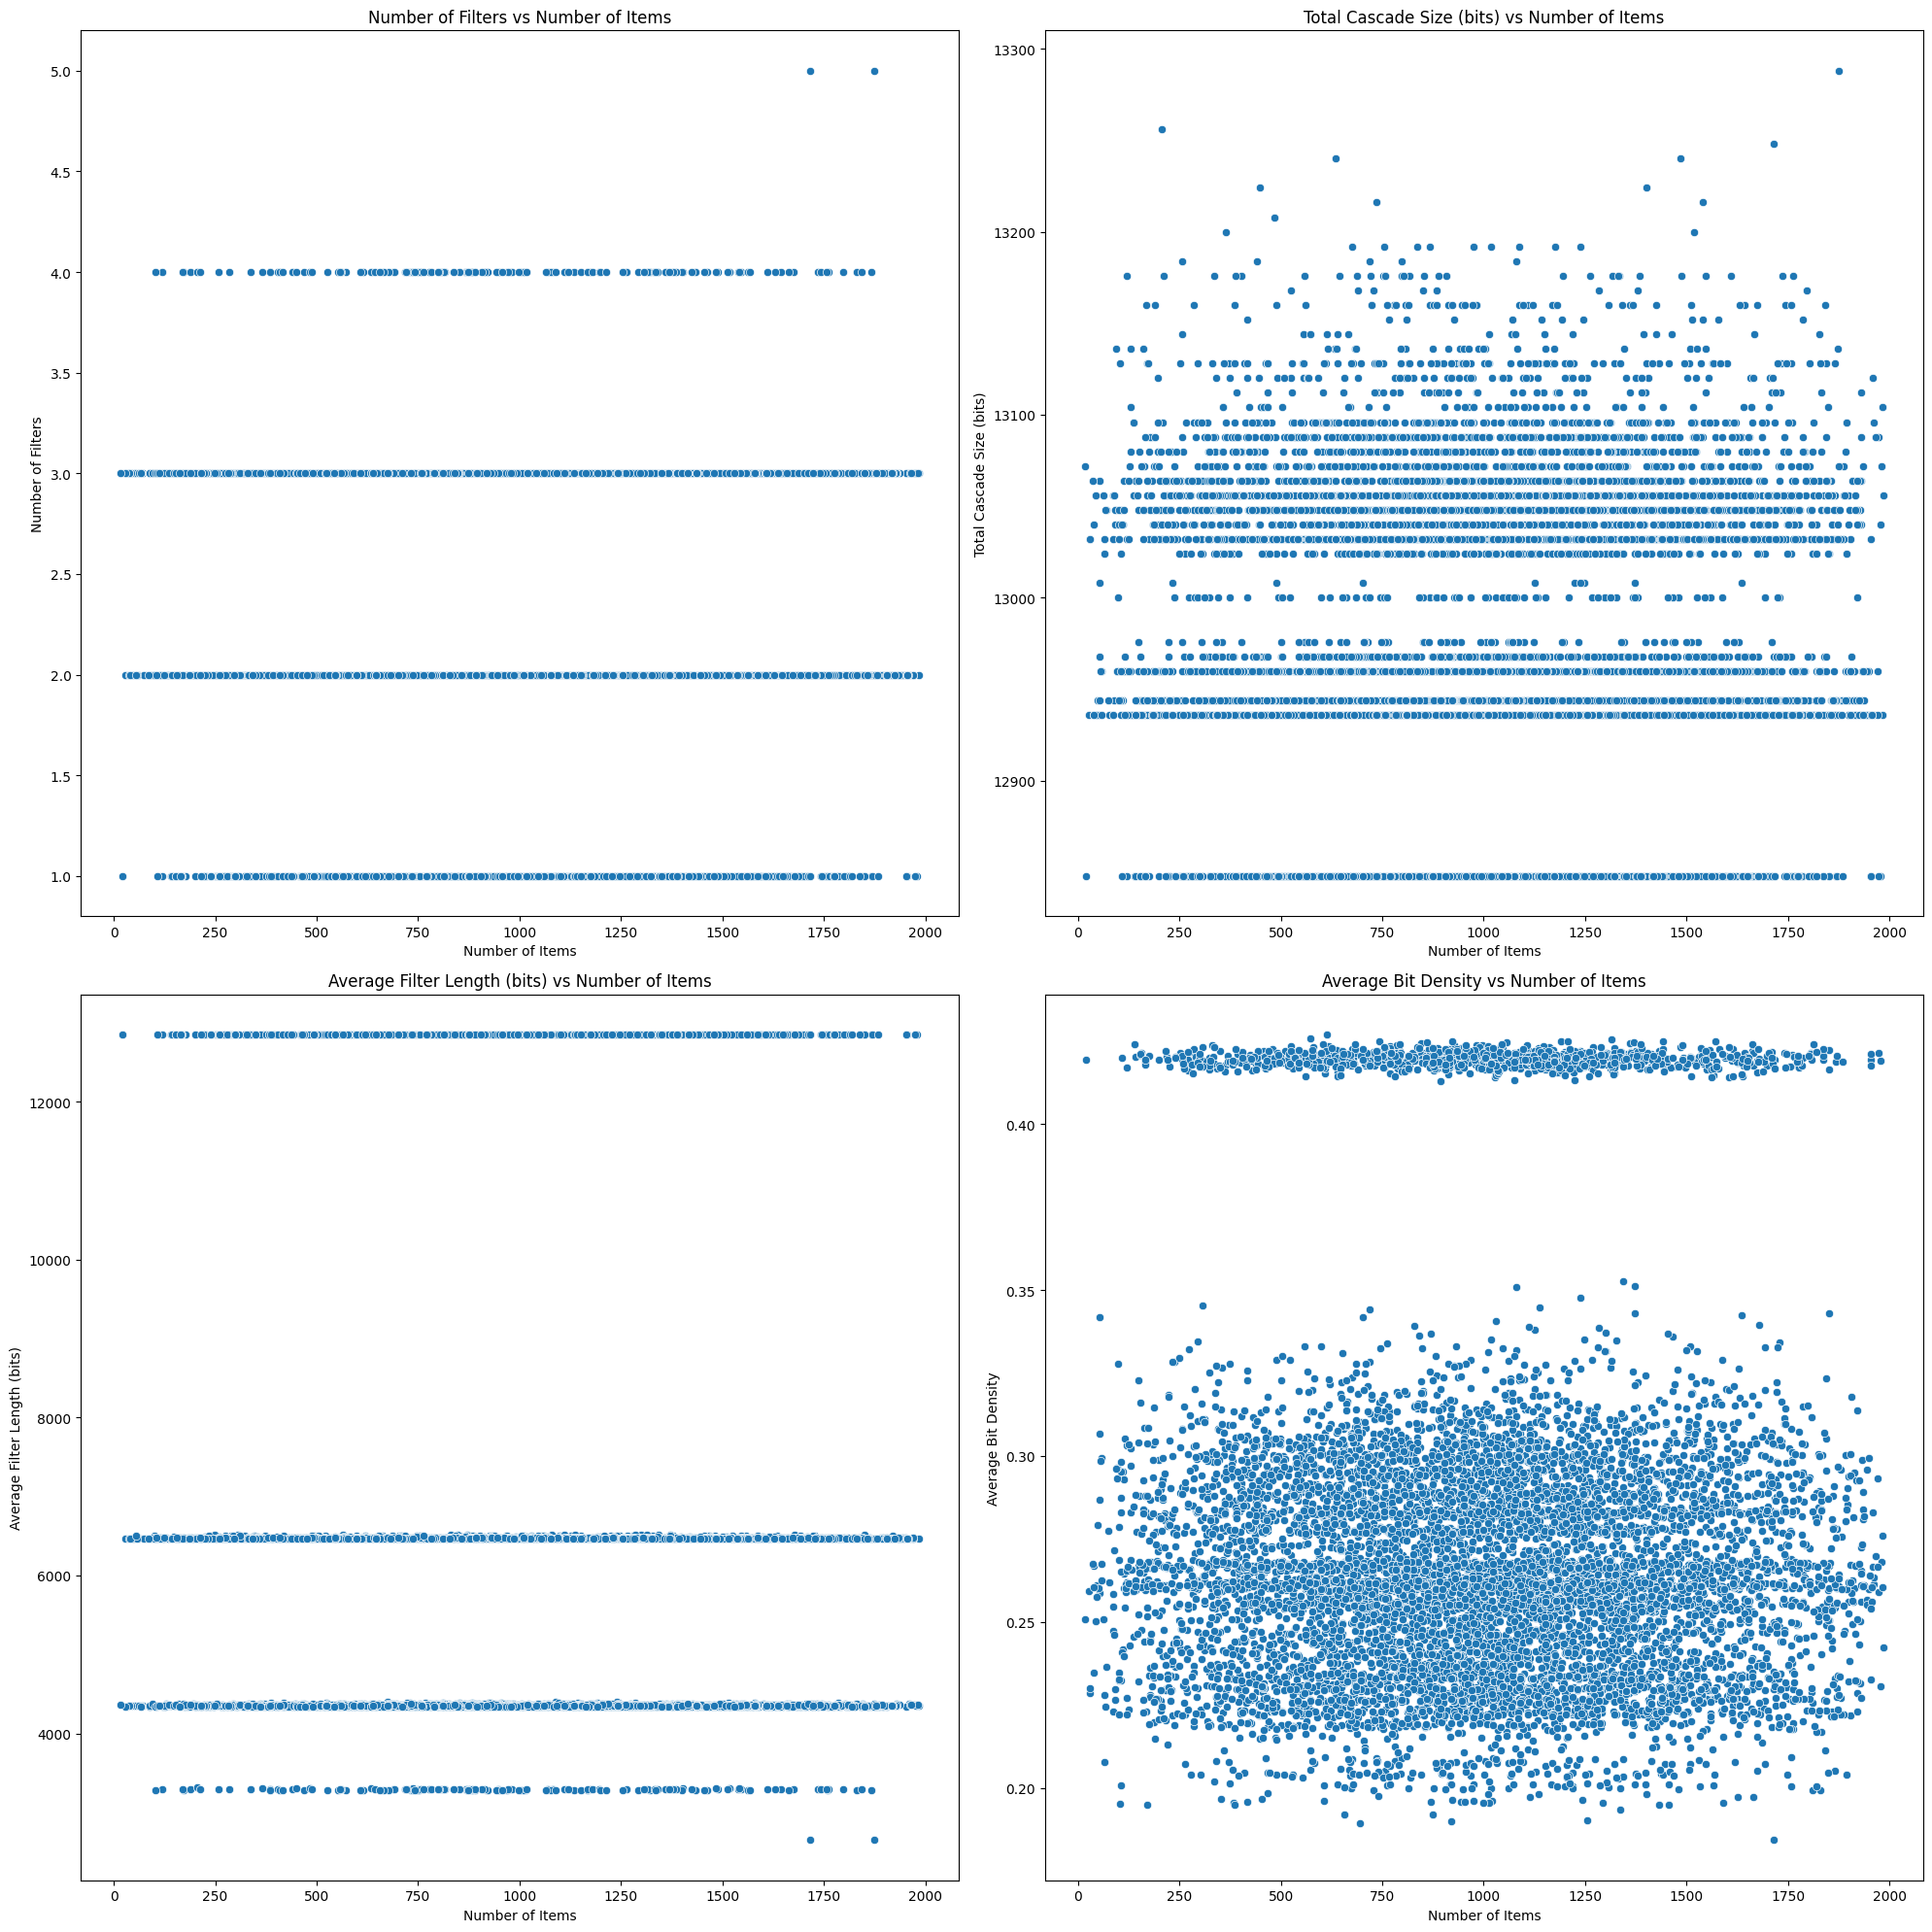

In [12]:
# 6. Relationship Analysis
print("\n6. Relationship Analysis")
df_y['total_items'] = df_y['num_included'] + df_y['num_excluded']
df_y['num_filters'] = num_filters
df_y['total_cascade_size'] = [sum(lengths) for lengths in filter_lengths]
df_y['avg_filter_length'] = [np.mean(lengths) for lengths in filter_lengths]
df_y['avg_bit_density'] = [np.mean(densities) for densities in bit_densities]

relationships = [
    ('total_items', 'num_filters', 'Number of Items', 'Number of Filters'),
    ('total_items', 'total_cascade_size', 'Number of Items', 'Total Cascade Size (bits)'),
    ('total_items', 'avg_filter_length', 'Number of Items', 'Average Filter Length (bits)'),
    ('total_items', 'avg_bit_density', 'Number of Items', 'Average Bit Density')
]

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, (x, y, x_label, y_label) in enumerate(relationships):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(data=df_y, x=x, y=y, ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{y_label} vs {x_label}')
plt.tight_layout()
plt.show()


Correlation matrix:
                    num_included  num_excluded  total_items  num_filters  \
num_included            1.000000      0.001226     0.705985    -0.001340   
num_excluded            0.001226      1.000000     0.709092     0.002053   
total_items             0.705985      0.709092     1.000000     0.000509   
num_filters            -0.001340      0.002053     0.000509     1.000000   
total_cascade_size     -0.001827     -0.000441    -0.001600     0.965063   
avg_filter_length      -0.000314      0.003128     0.001994    -0.913924   
avg_bit_density        -0.001990     -0.000348    -0.001650    -0.814977   

                    total_cascade_size  avg_filter_length  avg_bit_density  
num_included                 -0.001827          -0.000314        -0.001990  
num_excluded                 -0.000441           0.003128        -0.000348  
total_items                  -0.001600           0.001994        -0.001650  
num_filters                   0.965063          -0.913924     

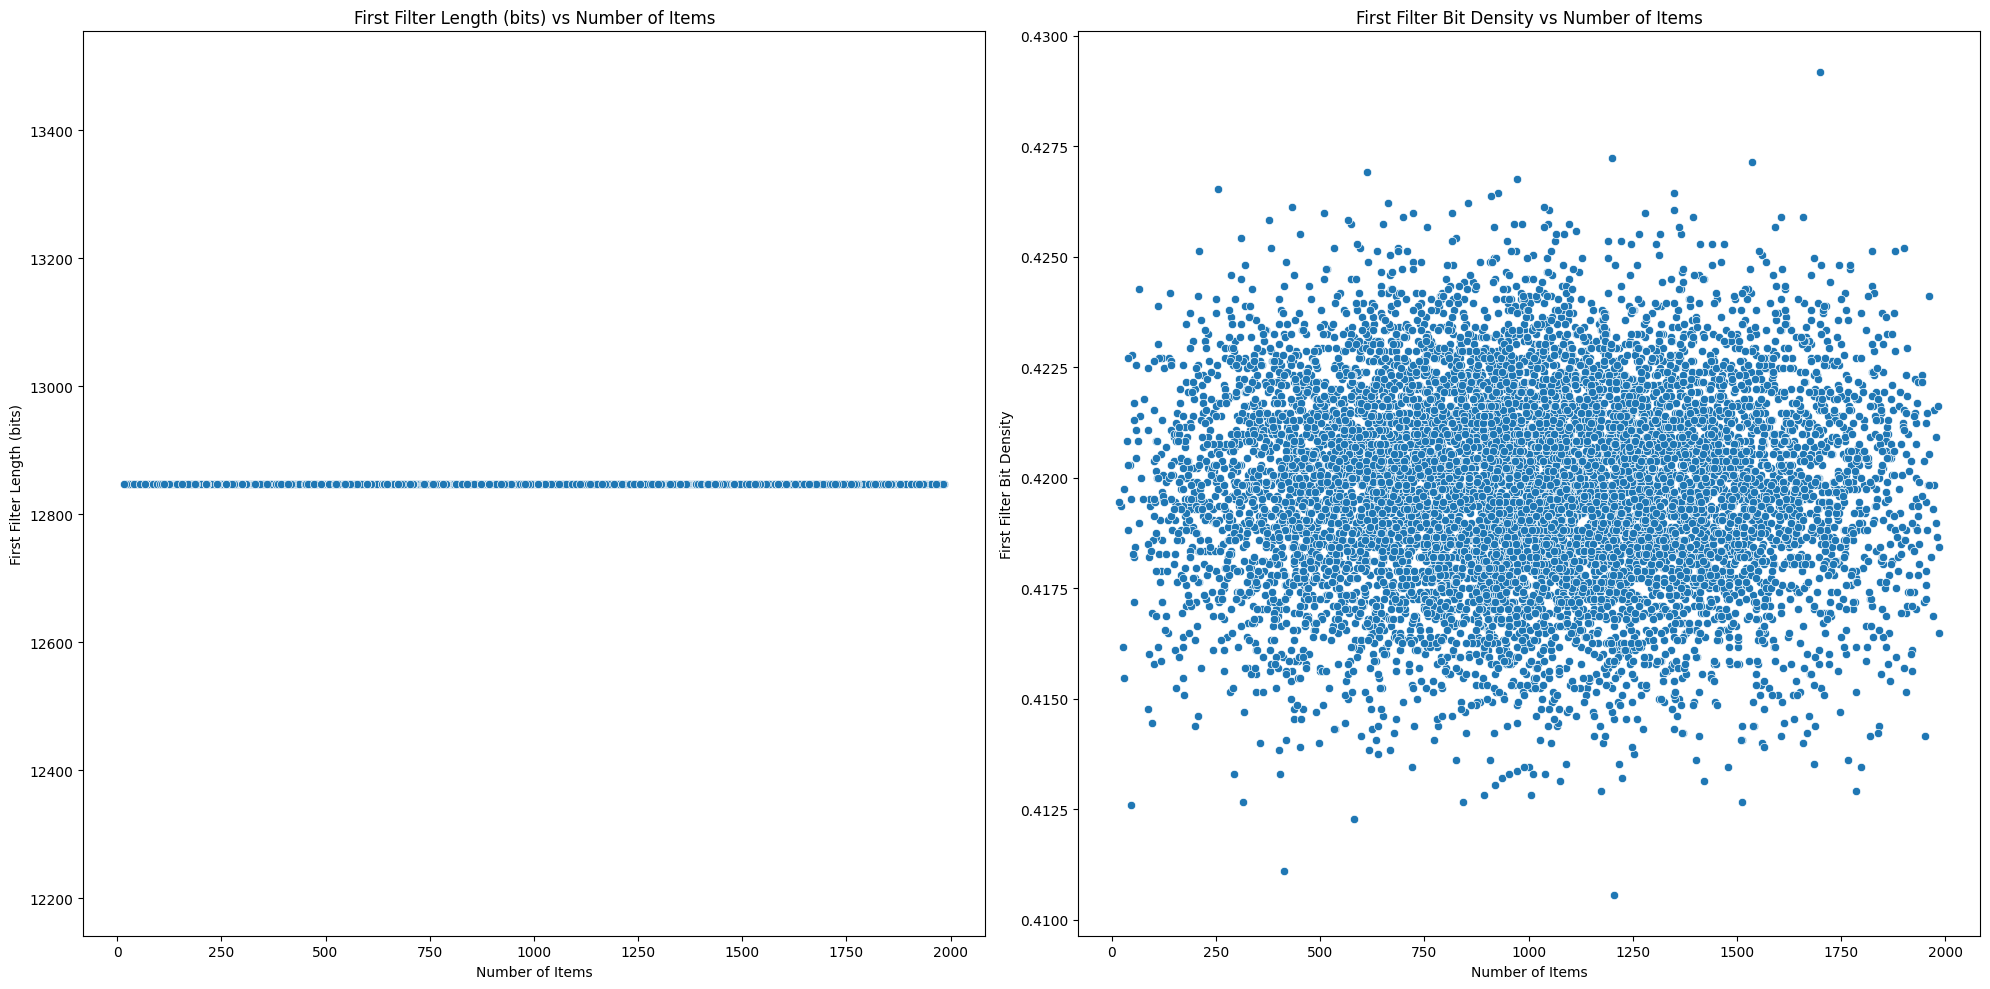

In [13]:
print("\nCorrelation matrix:")
print(df_y[['num_included', 'num_excluded', 'total_items', 'num_filters', 
            'total_cascade_size', 'avg_filter_length', 'avg_bit_density']].corr())

# Analyze first filter characteristics
df_y['first_filter_length'] = [lengths[0] if lengths else np.nan for lengths in filter_lengths]
df_y['first_filter_density'] = [densities[0] if densities else np.nan for densities in bit_densities]

first_filter_relationships = [
    ('total_items', 'first_filter_length', 'Number of Items', 'First Filter Length (bits)'),
    ('total_items', 'first_filter_density', 'Number of Items', 'First Filter Bit Density')
]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, (x, y, x_label, y_label) in enumerate(first_filter_relationships):
    ax = axes[i]
    sns.scatterplot(data=df_y, x=x, y=y, ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{y_label} vs {x_label}')
plt.tight_layout()
plt.show()